# PSNR / SSIM on RAW outputs

Replicates the evaluation in `models/ELD_model.py` using the saved RAW prediction (`*_raw_output.npy`) and ground truth RAW indicated in `*_file_names.json`.

In [1]:
from pathlib import Path
import sys
import json

import numpy as np
import rawpy
import tifffile

# Make project root importable
repo_root = Path("..").resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from util import index
from util import process
from dataset.sid_dataset import pack_raw_bayer

/opt/conda/envs/ci/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not get terminal width, defaulting to 80. Error: not enough values to unpack (expected 2, got 0)


In [2]:
import os;os.getcwd()

'/home/david.weijiecai/computational_imaging/ExposureDiffusion'

In [3]:
%cd /home/david.weijiecai/computational_imaging/ExposureDiffusion/notebooks/

/home/david.weijiecai/computational_imaging/ExposureDiffusion/notebooks


In [4]:
# Configure paths
base_dir = Path("../output/10003_00_0.04s")
meta_path = base_dir / "eld_iter_model_file_names.json"

# Find the saved RAW prediction (.npy); override here if needed
pred_npy_path = base_dir / "eld_iter_model_raw_output.npy"
if not pred_npy_path.exists():
    npy_candidates = list(base_dir.glob("*raw_output.npy"))
    if not npy_candidates:
        raise FileNotFoundError("No *_raw_output.npy found in output directory")
    pred_npy_path = npy_candidates[0]

for p in [pred_npy_path, meta_path]:
    if not p.exists():
        raise FileNotFoundError(f"Missing file: {p}")

In [5]:
def load_pred_raw(path: Path) -> np.ndarray:
    """Load saved RAW prediction (C,H,W) from .npy."""
    arr = np.load(path)
    if arr.ndim != 3:
        raise ValueError(f"Expected 3D array (C,H,W), got {arr.shape}")
    return arr


def load_gt_raw(path: Path) -> np.ndarray:
    """Load GT RAW and pack to 4-channel Bayer (C,H,W) in [0,1]."""
    with rawpy.imread(str(path)) as raw:
        return pack_raw_bayer(raw)


def to_uint8_hwc(arr_chw: np.ndarray) -> np.ndarray:
    """Mimic tensor2im: C,H,W -> H,W,C scaled to 0-255 and clipped."""
    hwc = np.transpose(arr_chw, (1, 2, 0)) * 255.0
    hwc = np.clip(hwc, 0, 255)
    return hwc.astype(np.float32)


def align_pair(pred: np.ndarray, gt: np.ndarray):
    """Crop to common H/W and match channel count (min of both)."""
    min_h = min(pred.shape[0], gt.shape[0])
    min_w = min(pred.shape[1], gt.shape[1])
    pred = pred[:min_h, :min_w]
    gt = gt[:min_h, :min_w]
    # Handle grayscale vs color or extra channels
    if pred.ndim == 2:
        pred = pred[..., None]
    if gt.ndim == 2:
        gt = gt[..., None]
    min_c = min(pred.shape[-1], gt.shape[-1])
    pred = pred[..., :min_c]
    gt = gt[..., :min_c]
    return pred, gt


def compute_metrics(pred_chw: np.ndarray, gt_chw: np.ndarray):
    pred_img = to_uint8_hwc(pred_chw)
    gt_img = to_uint8_hwc(gt_chw)
    pred_img, gt_img = align_pair(pred_img, gt_img)
    # Match model eval: data_range=255
    return index.quality_assess(pred_img, gt_img, data_range=255)

In [6]:
# Load metadata to resolve GT RAW path
with meta_path.open() as f:
    meta = json.load(f)
gt_raw_path = Path(os.getcwd()) / ".." / meta["gt_raw_path"]
if not gt_raw_path.exists():
    raise FileNotFoundError(f"GT RAW not found: {gt_raw_path}")

# Load data
pred_raw = load_pred_raw(pred_npy_path)
gt_raw = load_gt_raw(gt_raw_path)

# Metrics
metrics = compute_metrics(pred_raw, gt_raw)
print("RAW prediction vs GT RAW (demosaiced to HWC-like via tensor2im equivalent):", metrics)

X.shape: (1424, 2128, 4) Y.shape: (1424, 2128, 4)
RAW prediction vs GT RAW (demosaiced to HWC-like via tensor2im equivalent): {'PSNR': 33.92725219866112, 'SSIM': 0.7726935946498468}


In [7]:
# Metrics using the saved TIFF (convert back to CHW float)
tiff_path = base_dir / "eld_iter_model_raw_output.tiff"
if not tiff_path.exists():
    tiff_candidates = list(base_dir.glob("*raw_output.tiff"))
    if not tiff_candidates:
        raise FileNotFoundError("No *_raw_output.tiff found in output directory")
    tiff_path = tiff_candidates[0]

def load_pred_tiff(path: Path) -> np.ndarray:
    """Load saved TIFF (HWC uint16), invert the save transform -> CHW float32 [0,1]."""
    arr = tifffile.imread(str(path))
    if arr.ndim != 3:
        raise ValueError(f"Expected 3D HWC array, got {arr.shape}")
    chw = np.moveaxis(arr.astype(np.float32), -1, 0) / 65535.0
    return chw

pred_tiff_raw = load_pred_tiff(tiff_path)
tiff_metrics = compute_metrics(pred_tiff_raw, gt_raw)
print("TIFF prediction vs GT RAW (after inverting save transform):", tiff_metrics)

X.shape: (1424, 2128, 4) Y.shape: (1424, 2128, 4)
TIFF prediction vs GT RAW (after inverting save transform): {'PSNR': 33.9257801074787, 'SSIM': 0.7724320814340175}


In [11]:
gt_raw.shape

(4, 1424, 2128)

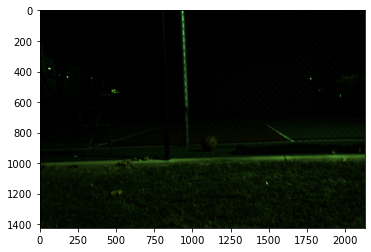

In [8]:
import matplotlib.pyplot as plt
# img_vis = pred_tiff_raw.clip(0, 1)
# img_vis = np.moveaxis(img_vis, 0, -1)
pr = pred_tiff_raw  # C,H,W
rgb = np.stack([pr[0], 0.5*(pr[1]+pr[3]), pr[2]], axis=-1)
plt.imshow(np.clip(rgb, 0, 1))

In [23]:
import rawpy
import numpy as np
from util import process  # has raw2rgb_v2, read_wb_ccm

pred_raw = np.load( Path(os.getcwd()) / base_dir / "eld_iter_model_raw_output.npy")  # C,H,W in [0,1]

with rawpy.imread(str(gt_raw_path)) as raw:  # gt_raw_path from meta json
    wb, ccm = process.read_wb_ccm(raw)
    
# rgb = process.raw2rgb_v2(pred_raw, wb, ccm)  # H,W,3 float in [0,1]
# rgb = np.swapaxes(rgb, 0, 2)
# rgb_rot = np.rot90(rgb, k=-1, axes=(0, 1))
# plt.figure(figsize=(12, 12))
# plt.imshow(np.clip(rgb_rot, 0, 1))
# plt.axis("off")
# plt.show()

def visualize_pred_raw(pred_raw: np.ndarray, wb: np.ndarray, ccm: np.ndarray):
    """Visualize predicted RAW (C,H,W) by converting to RGB using WB and CCM."""
    rgb = process.raw2rgb_v2(pred_raw, wb, ccm)  # H,W,3 float in [0,1]
    rgb = np.swapaxes(rgb, 0, 2)
    rgb_rot = np.rot90(rgb, k=-1, axes=(0, 1))
    plt.figure(figsize=(20, 20))
    plt.imshow(np.clip(rgb_rot, 0, 1))
    plt.axis("off")
    plt.show()

def visualize_gt_raw(gt_raw_path: Path):
    """Visualize GT RAW by converting to RGB using WB and CCM from the RAW file."""
    with rawpy.imread(str(gt_raw_path)) as raw:
        wb, ccm = process.read_wb_ccm(raw)
        gt_raw = pack_raw_bayer(raw)  # C,H,W in [0,1]
    visualize_pred_raw(gt_raw, wb, ccm)

In [ ]:
with rawpy.imread(str(gt_raw_path)) as raw:  # gt_raw_path from meta json
    wb, ccm = process.read_wb_ccm(raw)
visualize_pred_raw(pred_raw, wb, ccm)

In [ ]:
visualize_gt_raw(gt_raw_path)